##EE 399
##Sam Tam
##5/19/23
##HW 6


In [1]:
!git clone https://github.com/shervinsahba/pyshred

Cloning into 'pyshred'...
remote: Enumerating objects: 42, done.
remote: Counting objects: 100% (42/42), done.
remote: Compressing objects: 100% (32/32), done.
remote: Total 42 (delta 20), reused 26 (delta 9), pack-reused 0
Unpacking objects: 100% (42/42), 223.89 KiB | 5.09 MiB/s, done.


In [2]:
%cd pyshred

/content/pyshred


# **Part 1**

In [3]:
import numpy as np
from processdata import load_data
from processdata import TimeSeriesDataset
import models
import torch
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

num_sensors = 3 
lags = 52
load_X = load_data('SST')
n = load_X.shape[0]
m = load_X.shape[1]
sensor_locations = np.random.choice(m, size=num_sensors, replace=False)

In [4]:
train_indices = np.random.choice(n - lags, size=1000, replace=False)
mask = np.ones(n - lags)
mask[train_indices] = 0
valid_test_indices = np.arange(0, n - lags)[np.where(mask!=0)[0]]
valid_indices = valid_test_indices[::2]
test_indices = valid_test_indices[1::2]

In [5]:
sc = MinMaxScaler()
sc = sc.fit(load_X[train_indices])
transformed_X = sc.transform(load_X)

### Generate input sequences to a SHRED model
all_data_in = np.zeros((n - lags, lags, num_sensors))
for i in range(len(all_data_in)):
    all_data_in[i] = transformed_X[i:i+lags, sensor_locations]

### Generate training validation and test datasets both for reconstruction of states and forecasting sensors
device = 'cuda' if torch.cuda.is_available() else 'cpu'

train_data_in = torch.tensor(all_data_in[train_indices], dtype=torch.float32).to(device)
valid_data_in = torch.tensor(all_data_in[valid_indices], dtype=torch.float32).to(device)
test_data_in = torch.tensor(all_data_in[test_indices], dtype=torch.float32).to(device)

### -1 to have output be at the same time as final sensor measurements
train_data_out = torch.tensor(transformed_X[train_indices + lags - 1], dtype=torch.float32).to(device)
valid_data_out = torch.tensor(transformed_X[valid_indices + lags - 1], dtype=torch.float32).to(device)
test_data_out = torch.tensor(transformed_X[test_indices + lags - 1], dtype=torch.float32).to(device)

train_dataset = TimeSeriesDataset(train_data_in, train_data_out)
valid_dataset = TimeSeriesDataset(valid_data_in, valid_data_out)
test_dataset = TimeSeriesDataset(test_data_in, test_data_out)

In [9]:
shred = models.SHRED(num_sensors, m, hidden_size=64, hidden_layers=2, l1=350, l2=400, dropout=0.1).to(device)
validation_errors = models.fit(shred, train_dataset, valid_dataset, batch_size=64, num_epochs=1000, lr=1e-3, verbose=True, patience=5)

epoch: 960 valid_error: tensor(0.1105, device='cuda:0'):  96%|█████████▌| 959/1000 [02:35<00:06,  6.17it/s]


In [10]:
test_recons = sc.inverse_transform(shred(test_dataset.X).detach().cpu().numpy())
test_ground_truth = sc.inverse_transform(test_dataset.Y.detach().cpu().numpy())
print(np.linalg.norm(test_recons - test_ground_truth) / np.linalg.norm(test_ground_truth))

0.019370167


# **Part 2**

In [20]:
from processdata import load_full_SST

# SST data with world map indices for plotting
full_SST, sst_locs = load_full_SST()
full_test_truth = full_SST[test_indices, :]

# replacing SST data with our reconstruction
full_test_recon = full_test_truth.copy()
full_test_recon[:,sst_locs] = test_recons

# reshaping to 2d frames
for x in [full_test_truth, full_test_recon]:
    x.resize(len(x),180,360)

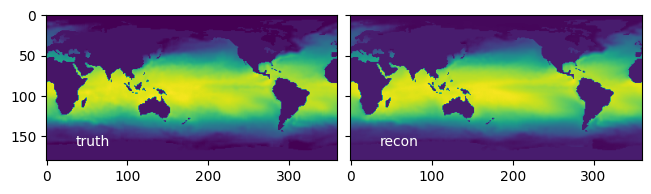

In [21]:
plotdata = [full_test_truth, full_test_recon]
labels = ['truth','recon']
fig, ax = plt.subplots(1,2,constrained_layout=True,sharey=True)
for axis,p,label in zip(ax, plotdata, labels):
    axis.imshow(p[0])
    axis.set_aspect('equal')
    axis.text(0.1,0.1,label,color='w',transform=axis.transAxes)

# **Part 3**

epoch: 1000 valid_error: tensor(0.2032, device='cuda:0'): 100%|██████████| 1000/1000 [02:30<00:00,  6.64it/s]
epoch: 880 valid_error: tensor(0.1323, device='cuda:0'):  88%|████████▊ | 879/1000 [02:13<00:18,  6.58it/s]
epoch: 1000 valid_error: tensor(0.1163, device='cuda:0'): 100%|██████████| 1000/1000 [02:33<00:00,  6.53it/s]
epoch: 1000 valid_error: tensor(0.1125, device='cuda:0'): 100%|██████████| 1000/1000 [02:34<00:00,  6.47it/s]
epoch: 1000 valid_error: tensor(0.1123, device='cuda:0'): 100%|██████████| 1000/1000 [02:35<00:00,  6.41it/s]


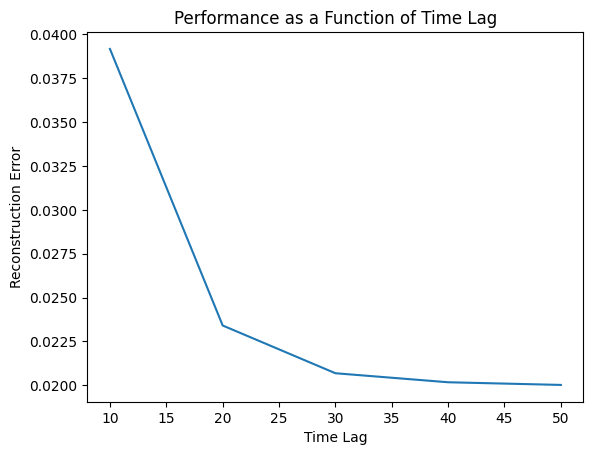

In [22]:
time_lag_values = [10, 20, 30, 40, 50]  # Example values for time lag

performance_metrics = []  # List to store the performance metrics for each time lag

for lags in time_lag_values:
    # Generate input sequences to a SHRED model
    all_data_in = np.zeros((n - lags, lags, num_sensors))
    for i in range(len(all_data_in)):
        all_data_in[i] = transformed_X[i:i+lags, sensor_locations]
    
    # Generate training, validation, and test datasets for state reconstruction and sensor forecasting
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    train_data_in = torch.tensor(all_data_in[train_indices], dtype=torch.float32).to(device)
    valid_data_in = torch.tensor(all_data_in[valid_indices], dtype=torch.float32).to(device)
    test_data_in = torch.tensor(all_data_in[test_indices], dtype=torch.float32).to(device)
    
    train_data_out = torch.tensor(transformed_X[train_indices + lags - 1], dtype=torch.float32).to(device)
    valid_data_out = torch.tensor(transformed_X[valid_indices + lags - 1], dtype=torch.float32).to(device)
    test_data_out = torch.tensor(transformed_X[test_indices + lags - 1], dtype=torch.float32).to(device)
    
    train_dataset = TimeSeriesDataset(train_data_in, train_data_out)
    valid_dataset = TimeSeriesDataset(valid_data_in, valid_data_out)
    test_dataset = TimeSeriesDataset(test_data_in, test_data_out)
    
    # Create and train the SHRED model
    shred = models.SHRED(num_sensors, m, hidden_size=64, hidden_layers=2, l1=350, l2=400, dropout=0.1).to(device)
    validation_errors = models.fit(shred, train_dataset, valid_dataset, batch_size=64, num_epochs=1000, lr=1e-3, verbose=True, patience=5)
    
    # Calculate reconstruction error
    test_recons = sc.inverse_transform(shred(test_dataset.X).detach().cpu().numpy())
    test_ground_truth = sc.inverse_transform(test_dataset.Y.detach().cpu().numpy())
    reconstruction_error = np.linalg.norm(test_recons - test_ground_truth) / np.linalg.norm(test_ground_truth)
    
    # Store the performance metric for the current time lag value
    performance_metrics.append(reconstruction_error)

# Plot the performance as a function of the time lag variable
plt.plot(time_lag_values, performance_metrics)
plt.xlabel('Time Lag')
plt.ylabel('Reconstruction Error')
plt.title('Performance as a Function of Time Lag')
plt.show()

# **Part 4**

epoch: 880 valid_error: tensor(0.1117, device='cuda:0'):  88%|████████▊ | 879/1000 [02:16<00:18,  6.44it/s]
epoch: 820 valid_error: tensor(0.1232, device='cuda:0'):  82%|████████▏ | 819/1000 [02:07<00:28,  6.44it/s]
epoch: 900 valid_error: tensor(0.1380, device='cuda:0'):  90%|████████▉ | 899/1000 [02:19<00:15,  6.44it/s]
epoch: 860 valid_error: tensor(0.1545, device='cuda:0'):  86%|████████▌ | 859/1000 [02:13<00:21,  6.43it/s]
epoch: 720 valid_error: tensor(0.1688, device='cuda:0'):  72%|███████▏  | 719/1000 [01:52<00:43,  6.41it/s]


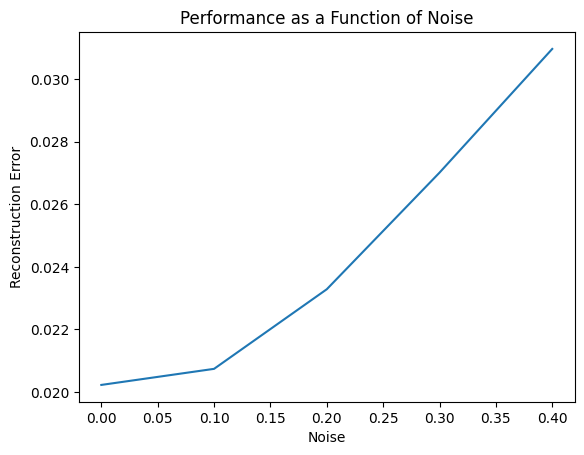

In [11]:
noise_levels = [0.0, 0.1, 0.2, 0.3, 0.4]  # Example noise levels to test

performance_metrics = []  # List to store the performance metrics for each noise level

for noise_level in noise_levels:
    # Add Gaussian noise to the data
    noisy_load_X = load_X + np.random.normal(loc=0, scale=noise_level, size=load_X.shape)
    
    # Normalize the noisy data
    sc = MinMaxScaler()
    sc.fit(noisy_load_X[train_indices])
    transformed_X = sc.transform(noisy_load_X)
    
    # Generate input sequences to a SHRED model
    all_data_in = np.zeros((n - lags, lags, num_sensors))
    for i in range(len(all_data_in)):
        all_data_in[i] = transformed_X[i:i+lags, sensor_locations]
    
    # Generate training, validation, and test datasets for state reconstruction and sensor forecasting
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    train_data_in = torch.tensor(all_data_in[train_indices], dtype=torch.float32).to(device)
    valid_data_in = torch.tensor(all_data_in[valid_indices], dtype=torch.float32).to(device)
    test_data_in = torch.tensor(all_data_in[test_indices], dtype=torch.float32).to(device)
    
    train_data_out = torch.tensor(transformed_X[train_indices + lags - 1], dtype=torch.float32).to(device)
    valid_data_out = torch.tensor(transformed_X[valid_indices + lags - 1], dtype=torch.float32).to(device)
    test_data_out = torch.tensor(transformed_X[test_indices + lags - 1], dtype=torch.float32).to(device)
    
    train_dataset = TimeSeriesDataset(train_data_in, train_data_out)
    valid_dataset = TimeSeriesDataset(valid_data_in, valid_data_out)
    test_dataset = TimeSeriesDataset(test_data_in, test_data_out)
    
    # Create and train the SHRED model
    shred = models.SHRED(num_sensors, m, hidden_size=64, hidden_layers=2, l1=350, l2=400, dropout=0.1).to(device)
    validation_errors = models.fit(shred, train_dataset, valid_dataset, batch_size=64, num_epochs=1000, lr=1e-3, verbose=True, patience=5)
    
    # Code to evaluate and store the performance metric
    test_recons = sc.inverse_transform(shred(test_dataset.X).detach().cpu().numpy())
    test_ground_truth = sc.inverse_transform(test_dataset.Y.detach().cpu().numpy())
    reconstruction_error = np.linalg.norm(test_recons - test_ground_truth) / np.linalg.norm(test_ground_truth)
    performance_metrics.append(reconstruction_error)

# Plot the performance as a function of the noise variable
plt.plot(noise_levels, performance_metrics)
plt.xlabel('Noise')
plt.ylabel('Reconstruction Error')
plt.title('Performance as a Function of Noise')
plt.show()

# **Part 5**

epoch: 780 valid_error: tensor(0.1701, device='cuda:0'):  78%|███████▊  | 779/1000 [02:01<00:34,  6.41it/s]
epoch: 720 valid_error: tensor(0.1690, device='cuda:0'):  72%|███████▏  | 719/1000 [01:52<00:43,  6.41it/s]
epoch: 600 valid_error: tensor(0.1691, device='cuda:0'):  60%|█████▉    | 599/1000 [01:33<01:02,  6.40it/s]
epoch: 760 valid_error: tensor(0.1689, device='cuda:0'):  76%|███████▌  | 759/1000 [01:58<00:37,  6.41it/s]
epoch: 780 valid_error: tensor(0.1685, device='cuda:0'):  78%|███████▊  | 779/1000 [02:01<00:34,  6.41it/s]


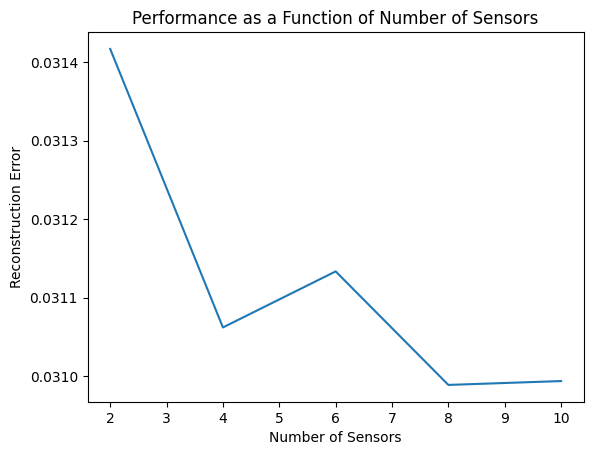

In [12]:
num_sensor_values = [2, 4, 6, 8, 10]  # Example values for the number of sensors

performance_metrics = []  # List to store the performance metrics for each number of sensors

for num_sensors in num_sensor_values:
    # Update the number of sensors in the code
    sensor_locations = np.random.choice(m, size=num_sensors, replace=False)
    
    # Generate input sequences to a SHRED model
    all_data_in = np.zeros((n - lags, lags, num_sensors))
    for i in range(len(all_data_in)):
        all_data_in[i] = transformed_X[i:i+lags, sensor_locations]
    
    # Generate training, validation, and test datasets for state reconstruction and sensor forecasting
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    train_data_in = torch.tensor(all_data_in[train_indices], dtype=torch.float32).to(device)
    valid_data_in = torch.tensor(all_data_in[valid_indices], dtype=torch.float32).to(device)
    test_data_in = torch.tensor(all_data_in[test_indices], dtype=torch.float32).to(device)
    
    train_data_out = torch.tensor(transformed_X[train_indices + lags - 1], dtype=torch.float32).to(device)
    valid_data_out = torch.tensor(transformed_X[valid_indices + lags - 1], dtype=torch.float32).to(device)
    test_data_out = torch.tensor(transformed_X[test_indices + lags - 1], dtype=torch.float32).to(device)
    
    train_dataset = TimeSeriesDataset(train_data_in, train_data_out)
    valid_dataset = TimeSeriesDataset(valid_data_in, valid_data_out)
    test_dataset = TimeSeriesDataset(test_data_in, test_data_out)
    
    # Create and train the SHRED model
    shred = models.SHRED(num_sensors, m, hidden_size=64, hidden_layers=2, l1=350, l2=400, dropout=0.1).to(device)
    validation_errors = models.fit(shred, train_dataset, valid_dataset, batch_size=64, num_epochs=1000, lr=1e-3, verbose=True, patience=5)
    # Code to evaluate and store the performance metric
    test_recons = sc.inverse_transform(shred(test_dataset.X).detach().cpu().numpy())
    test_ground_truth = sc.inverse_transform(test_dataset.Y.detach().cpu().numpy())
    reconstruction_error = np.linalg.norm(test_recons - test_ground_truth) / np.linalg.norm(test_ground_truth)
    performance_metrics.append(reconstruction_error)

# Plot the performance as a function of the number of sensors variable
plt.plot(num_sensor_values, performance_metrics)
plt.xlabel('Number of Sensors')
plt.ylabel('Reconstruction Error')
plt.title('Performance as a Function of Number of Sensors')
plt.show()